# Classificação de Elementos Transponíveis

Projeto prático da disciplina *SCC0271 - Introdução à Bioinformática*

## Integrantes

* Alexandre E. de Souza - alexandre_souza@usp.br - 12559506
* Eduardo Zaffari Monteiro - eduardozaffarimonteiro@usp.br - 12559490

In [1]:
# Bibliotecas
from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob

# Construção do Dataset

In [2]:
# Utilizamos glob para puxar todos os arquivos e contruir o Dataframe
df_all_files = pd.DataFrame()
for file in glob.glob('dados_gff3/*.gff3'):
    df_temp = pd.read_csv(file, sep='\t', header=None)
    df_all_files = pd.concat([df_all_files, df_temp])

In [3]:
# Renomeia as colunas para os nomes corretos
df_all_files = df_all_files.rename({
    0: 'Chr',
    1: 'Source Annotation',
    2: 'Class_Order_Superfamily',
    3: 'Start',
    4: 'End',
    5: 'Score',
    6: 'Strand',
    7: 'Phase',
    8: 'Attributes'
}, axis=1)

In [4]:
# Separa Class, Order e Superfamily
temp_col = df_all_files['Class_Order_Superfamily'].str.split('/')
df_all_files['Class'] = temp_col.str[0]
df_all_files['Order'] = temp_col.str[1]
df_all_files['SuperFamily'] = temp_col.str[2]
df_all_files = df_all_files.drop('Class_Order_Superfamily', axis=1)

In [5]:
# Filtra as strands positivas, conforme especificação
df_filtered = df_all_files[df_all_files['Strand'] == '+']

In [6]:
# Formata os cromossomos com zeros à esquerda
df_filtered.loc[:, 'Chr'] = df_filtered['Chr'].str.pad(
    width=2, side='left', fillchar='0')

In [7]:
# Seleciona as colunas necessarias e renomeia a coluna target
df_selected = df_filtered[['Chr', 'Start', 'End', 'Class']].rename(
    {'Class': '[Target] Class'}, axis=1)

In [8]:
# Le as sequencias dos arquivos fasta
sequences = {}
for i, fasta_file in enumerate(glob.glob('dados_fasta/*.fasta'), start=1):
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences[fasta_file.replace('dados_fasta\\sequence', '').replace(
            '.fasta', '')] = record.seq

In [9]:
# Filtrando apenas os TEs com cromossomos válidos
chromossomes = list(sequences.keys())

df_selected = df_selected[df_selected['Chr'].isin(chromossomes)]

In [10]:
# Função que encontra o Elemento Transponível dentro da sequencia
def find_sequence(row: tuple) -> str:
    start = row['Start']
    end = row['End']
    chr = row['Chr']

    seq = sequences[chr]

    transp_ele = seq[start:end]

    return transp_ele

In [11]:
# Aplica a função acima para encontrar o elemento transponível
df_selected['Seq'] = df_selected.apply(find_sequence, axis=1)
df_selected[['Chr', 'Seq', '[Target] Class']]

Chr                                                Seq  \
2       07  (A, G, C, T, T, C, G, T, C, A, C, C, A, G, C, ...   
3       01  (T, C, A, G, G, G, T, T, G, C, T, T, C, T, T, ...   
7       08  (C, G, C, C, C, A, A, G, C, A, G, A, C, G, G, ...   
11      05  (A, T, G, C, C, A, A, G, T, C, G, T, G, T, C, ...   
12      09  (T, T, A, G, G, T, T, A, T, T, T, A, T, A, T, ...   
...     ..                                                ...   
165161  02  (C, A, G, G, A, G, A, T, A, T, A, T, T, G, A, ...   
165162  01  (T, C, C, C, T, C, A, T, G, C, C, A, A, T, G, ...   
165164  04  (T, A, T, C, T, C, A, G, A, G, C, C, A, A, T, ...   
165165  04  (T, G, G, C, G, T, A, T, T, G, T, C, G, C, G, ...   
165166  01  (C, A, C, T, G, G, A, C, C, A, G, T, C, T, T, ...   

             [Target] Class  
2       Class II subclass 2  
3       Class II subclass 2  
7       Class II subclass 2  
11      Class II subclass 2  
12      Class II subclass 2  
...                     ...  
165161  Class II subclass 1  
165162  Class II subclass 1  
165164  Class II subclass 1  
165165  Class II subclass 1  
165166  Class II subclass 1  

[338334 rows x 3 columns]

In [12]:
# Substituindo classes por códigos para facilitar no uso do MathFeature
classes = {'Class I': 0,
           'Class II subclass I': 1,
           'Class II subclass 1': 2,
           'Class II subclass 2': 3}

In [13]:
# Cria o dataframe auxiliar para utilizarmos no MathFeature
df_aux = df_selected[['Chr', 'Seq', '[Target] Class']]
df_aux['[Target] Class'] = df_aux['[Target] Class'].map(classes)

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_7436\341958814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['[Target] Class'] = df_aux['[Target] Class'].map(classes)


In [14]:
# Remove caracteres extras e nulos do dataframe auxiliar
df_aux = df_aux[df_aux['Seq'].str.strip() != '']
df_aux

Chr                                                Seq  [Target] Class
2       07  (A, G, C, T, T, C, G, T, C, A, C, C, A, G, C, ...               3
3       01  (T, C, A, G, G, G, T, T, G, C, T, T, C, T, T, ...               3
7       08  (C, G, C, C, C, A, A, G, C, A, G, A, C, G, G, ...               3
11      05  (A, T, G, C, C, A, A, G, T, C, G, T, G, T, C, ...               3
12      09  (T, T, A, G, G, T, T, A, T, T, T, A, T, A, T, ...               3
...     ..                                                ...             ...
165161  02  (C, A, G, G, A, G, A, T, A, T, A, T, T, G, A, ...               2
165162  01  (T, C, C, C, T, C, A, T, G, C, C, A, A, T, G, ...               2
165164  04  (T, A, T, C, T, C, A, G, A, G, C, C, A, A, T, ...               2
165165  04  (T, G, G, C, G, T, A, T, T, G, T, C, G, C, G, ...               2
165166  01  (C, A, C, T, G, G, A, C, C, A, G, T, C, T, T, ...               2

[338211 rows x 3 columns]

In [15]:
# Escreve o dataframe auxiliar como arquivo fasta
with open('sequences.fasta', 'w') as fasta_file:
    for index, row in df_aux.iterrows():
        fasta_file.write(f">chr|{row['Chr']}|class|{row['[Target] Class']}|\n{row['Seq']}\n")

Aqui foi utilizada a ferramenta MathFeature para obter o arquivo dataset.csv, utilizado a partir desse momento.

# Leitura do Dataset

In [16]:
# Lendo o dataset do arquivo csv
dataset = pd.read_csv('dataset.csv')
dataset

nameseq  average        median     maximum     minimum  \
0       chr|05|class|0|  17858.0  11383.472686  81775546.0  147.712532   
1       chr|09|class|0|    412.0    246.106847     45866.0   26.606489   
2       chr|04|class|3|  18533.0  12144.603828  86908177.0  315.504222   
3       chr|08|class|0|     80.0     46.018077      1812.0   11.094314   
4       chr|09|class|2|    200.0    130.095076     10322.0   12.000000   
...                 ...      ...           ...         ...         ...   
169100  chr|04|class|3|  18641.0  12193.900510  87946055.0  361.647575   
169101  chr|10|class|0|  12587.0   8141.482453  40899383.0  298.702850   
169102  chr|04|class|0|    408.0    276.568813     43210.0   45.382880   
169103  chr|05|class|0|    394.0    244.664221     44062.0   16.896788   
169104  chr|06|class|2|     60.0     37.427206       998.0    6.281174   

            peak  none_levated_peak  sample_standard_deviation  \
0       0.333333          29.285927              611940.289138   
1       0.333333           4.366813                2249.895553   
2       0.333333          29.604027              638334.261230   
3       0.333333           1.918536                 199.333891   
4       0.333333           2.974564                 724.064914   
...          ...                ...                        ...   
169100  0.333333          29.766224              644095.175171   
169101  0.333333          24.547688              364512.983835   
169102  0.333333           4.286144                2128.343957   
169103  0.333333           4.337669                2210.694009   
169104  0.333333           1.620823                 125.880896   

        population_standard_deviation  percentile15  ...  percentile50  \
0                       611957.423363   5542.631305  ...  11383.472686   
1                         2252.630989    134.468533  ...    246.106847   
2                       638351.483485   5918.862739  ...  12144.603828   
3                          200.591530     21.421319  ...     46.018077   
4                          725.881893     59.739385  ...    130.095076   
...                               ...           ...  ...           ...   
169100                  644112.452170   5847.230575  ...  12193.900510   
169101                  364527.464438   3946.789309  ...   8141.482453   
169102                    2130.957026    134.426877  ...    276.568813   
169103                    2213.504810    106.577413  ...    244.664221   
169104                     126.943201     21.152479  ...     37.427206   

        percentile75     amplitude      variance  interquartile_range  \
0       17169.126634  8.177540e+07  3.744919e+11          9960.265521   
1         395.811586  4.583939e+04  5.074346e+06           233.561823   
2       18095.564384  8.690786e+07  4.074926e+11         10430.422376   
3          84.499099  1.800906e+03  4.023696e+04            55.799264   
4         181.318799  1.031000e+04  5.269045e+05           100.599818   
...              ...           ...           ...                  ...   
169100  18028.629009  8.794569e+07  4.148809e+11         10344.892291   
169101  12036.256247  4.089908e+07  1.328803e+11          6909.270012   
169102    392.504656  4.316462e+04  4.540978e+06           218.852793   
169103    358.765585  4.404510e+04  4.899604e+06           211.159623   
169104     48.000000  9.917188e+02  1.611458e+04            26.000000   

        semi_interquartile_range  coefficient_of_variation  skewness  \
0                    4980.132760                 34.267011  0.031741   
1                     116.780912                  5.460912  0.221201   
2                    5215.211188                 34.443116  0.030024   
3                      27.899632                  2.491674  0.511432   
4                      50.299909                  3.620325  0.289635   
...                          ...                       ...       ...   
169100               5172.446145                 34.552609  0.03

In [17]:
# Funções auxiliares para extrair informações das sequências
get_chr = lambda row: row['nameseq'][4:6] 
get_class = lambda row: row['nameseq'][-2:-1]

In [18]:
# Criando novas colunas
dataset['chr'] = dataset.apply(get_chr, axis=1)
dataset['class'] = dataset.apply(get_class, axis=1)

# Formatando as colunas
dataset = dataset.drop('label', axis=1)
dataset = dataset.drop('nameseq', axis=1)

dataset

average        median     maximum     minimum      peak  \
0       17858.0  11383.472686  81775546.0  147.712532  0.333333   
1         412.0    246.106847     45866.0   26.606489  0.333333   
2       18533.0  12144.603828  86908177.0  315.504222  0.333333   
3          80.0     46.018077      1812.0   11.094314  0.333333   
4         200.0    130.095076     10322.0   12.000000  0.333333   
...         ...           ...         ...         ...       ...   
169100  18641.0  12193.900510  87946055.0  361.647575  0.333333   
169101  12587.0   8141.482453  40899383.0  298.702850  0.333333   
169102    408.0    276.568813     43210.0   45.382880  0.333333   
169103    394.0    244.664221     44062.0   16.896788  0.333333   
169104     60.0     37.427206       998.0    6.281174  0.333333   

        none_levated_peak  sample_standard_deviation  \
0               29.285927              611940.289138   
1                4.366813                2249.895553   
2               29.604027              638334.261230   
3                1.918536                 199.333891   
4                2.974564                 724.064914   
...                   ...                        ...   
169100          29.766224              644095.175171   
169101          24.547688              364512.983835   
169102           4.286144                2128.343957   
169103           4.337669                2210.694009   
169104           1.620823                 125.880896   

        population_standard_deviation  percentile15  percentile25  ...  \
0                       611957.423363   5542.631305   7208.861114  ...   
1                         2252.630989    134.468533    162.249763  ...   
2                       638351.483485   5918.862739   7665.142008  ...   
3                          200.591530     21.421319     28.699836  ...   
4                          725.881893     59.739385     80.718981  ...   
...                               ...           ...           ...  ...   
169100                  644112.452170   5847.230575   7683.736719  ...   
169101                  364527.464438   3946.789309   5126.986235  ...   
169102                    2130.957026    134.426877    173.651863  ...   
169103                    2213.504810    106.577413    147.605962  ...   
169104                     126.943201     21.152479     22.000000  ...   

        percentile75     amplitude      variance  interquartile_range  \
0       17169.126634  8.177540e+07  3.744919e+11          9960.265521   
1         395.811586  4.583939e+04  5.074346e+06           233.561823   
2       18095.564384  8.690786e+07  4.074926e+11         10430.422376   
3          84.499099  1.800906e+03  4.023696e+04            55.799264   
4         181.318799  1.031000e+04  5.269045e+05           100.599818   
...              ...           ...           ...                  ...   
169100  18028.629009  8.794569e+07  4.148809e+11         10344.892291   
169101  12036.256247  4.089908e+07  1.328803e+11          6909.270012   
169102    392.504656  4.316462e+04  4.540978e+06           218.852793   
169103    358.765585  4.404510e+04  4.899604e+06           211.159623   
169104     48.000000  9.917188e+02  1.611458e+04            26.000000   

        semi_interquartile_range  coefficient_of_variation  skewness  \
0                    4980.132760                 34.267011  0.031741   
1                     116.780912                  5.460912  0.221201   
2                    5215.211188                 34.443116  0.030024   
3                      27.899632                  2.491674  0.511432   
4                      50.299909                  3.620325  0.289635   
...                          ...                       ...       ...   
169100               5172.446145                 34.552609  0.030029   
169101               3454.635006                 28.959481  0.036587   
169102                109.426396                  5.216529  0.185258   
169103                105.579812            

# Pré-processamento

A matriz de correlação abaixo irá guiar a etapa de pré-processamento

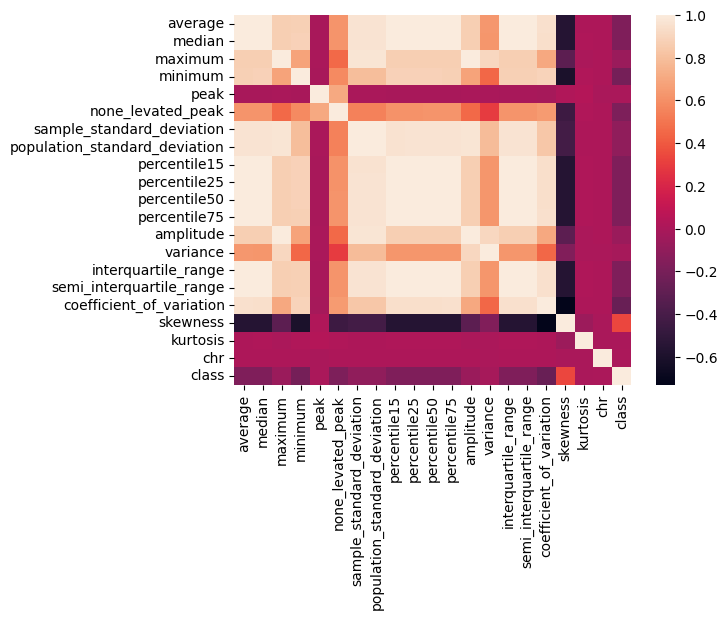

In [19]:
# Criando a Matriz de Correlação
corr_matrix = dataset.corr()

# Gerando e exibindo o heatmap
sns.heatmap(corr_matrix)
plt.show()

## Tratamento de missings

In [20]:
# Substitua valores infinitos por NaN 
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separando a base em variáveis explicativas e target
X = dataset.drop(['class', 'chr'], axis=1)
y = dataset['class']

# Como as variáveis que possuem valores faltantes tem uma leve correlação com a target, seus valores Nan serão imputados
X = X.fillna(X.median())

X

average        median     maximum     minimum      peak  \
0       17858.0  11383.472686  81775546.0  147.712532  0.333333   
1         412.0    246.106847     45866.0   26.606489  0.333333   
2       18533.0  12144.603828  86908177.0  315.504222  0.333333   
3          80.0     46.018077      1812.0   11.094314  0.333333   
4         200.0    130.095076     10322.0   12.000000  0.333333   
...         ...           ...         ...         ...       ...   
169100  18641.0  12193.900510  87946055.0  361.647575  0.333333   
169101  12587.0   8141.482453  40899383.0  298.702850  0.333333   
169102    408.0    276.568813     43210.0   45.382880  0.333333   
169103    394.0    244.664221     44062.0   16.896788  0.333333   
169104     60.0     37.427206       998.0    6.281174  0.333333   

        none_levated_peak  sample_standard_deviation  \
0               29.285927              611940.289138   
1                4.366813                2249.895553   
2               29.604027              638334.261230   
3                1.918536                 199.333891   
4                2.974564                 724.064914   
...                   ...                        ...   
169100          29.766224              644095.175171   
169101          24.547688              364512.983835   
169102           4.286144                2128.343957   
169103           4.337669                2210.694009   
169104           1.620823                 125.880896   

        population_standard_deviation  percentile15  percentile25  \
0                       611957.423363   5542.631305   7208.861114   
1                         2252.630989    134.468533    162.249763   
2                       638351.483485   5918.862739   7665.142008   
3                          200.591530     21.421319     28.699836   
4                          725.881893     59.739385     80.718981   
...                               ...           ...           ...   
169100                  644112.452170   5847.230575   7683.736719   
169101                  364527.464438   3946.789309   5126.986235   
169102                    2130.957026    134.426877    173.651863   
169103                    2213.504810    106.577413    147.605962   
169104                     126.943201     21.152479     22.000000   

        percentile50  percentile75     amplitude      variance  \
0       11383.472686  17169.126634  8.177540e+07  3.744919e+11   
1         246.106847    395.811586  4.583939e+04  5.074346e+06   
2       12144.603828  18095.564384  8.690786e+07  4.074926e+11   
3          46.018077     84.499099  1.800906e+03  4.023696e+04   
4         130.095076    181.318799  1.031000e+04  5.269045e+05   
...              ...           ...           ...           ...   
169100  12193.900510  18028.629009  8.794569e+07  4.148809e+11   
169101   8141.482453  12036.256247  4.089908e+07  1.328803e+11   
169102    276.568813    392.504656  4.316462e+04  4.540978e+06   
169103    244.664221    358.765585  4.404510e+04  4.899604e+06   
169104     37.427206     48.000000  9.917188e+02  1.611458e+04   

        interquartile_range  semi_interquartile_range  \
0               9960.265521               4980.132760   
1                233.561823                116.780912   
2              10430.422376               5215.211188   
3                 55.799264                 27.899632   
4                100.599818                 50.299909   
...                     ...                       ...   
169100         10344.892291               5172.446145   
169101          6909.270012               3454.635006   
169102           218.852793                109.426396   
169103           211.159623                105.579812   
169104            26.000000                 13.000000   

        coefficient_of_variation  skewness  kurtosis  
0                      34.267011  0.031741  0.262307  
1                       5.460912  0.221201  0.246461  
2                      34.443116  0.030024  0.261457  
3  

## Separando o Dataset

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Normalização

In [22]:
# Normalizando as variáveis a partir da média
X_train_normalized = (X_train - X_train.mean())/X_train.std()

# Normalizando os dados de teste
X_test_normalized = (X_test - X_test.mean())/X_test.std()

## *Feature Selection*

Para a seleção de variáveis, será usado um estimador de Ridge Regression. Os coeficientes do estimador representam a importância de cada uma das variáveis, e aquelas com os maiores coeficientes serão selecionadas.

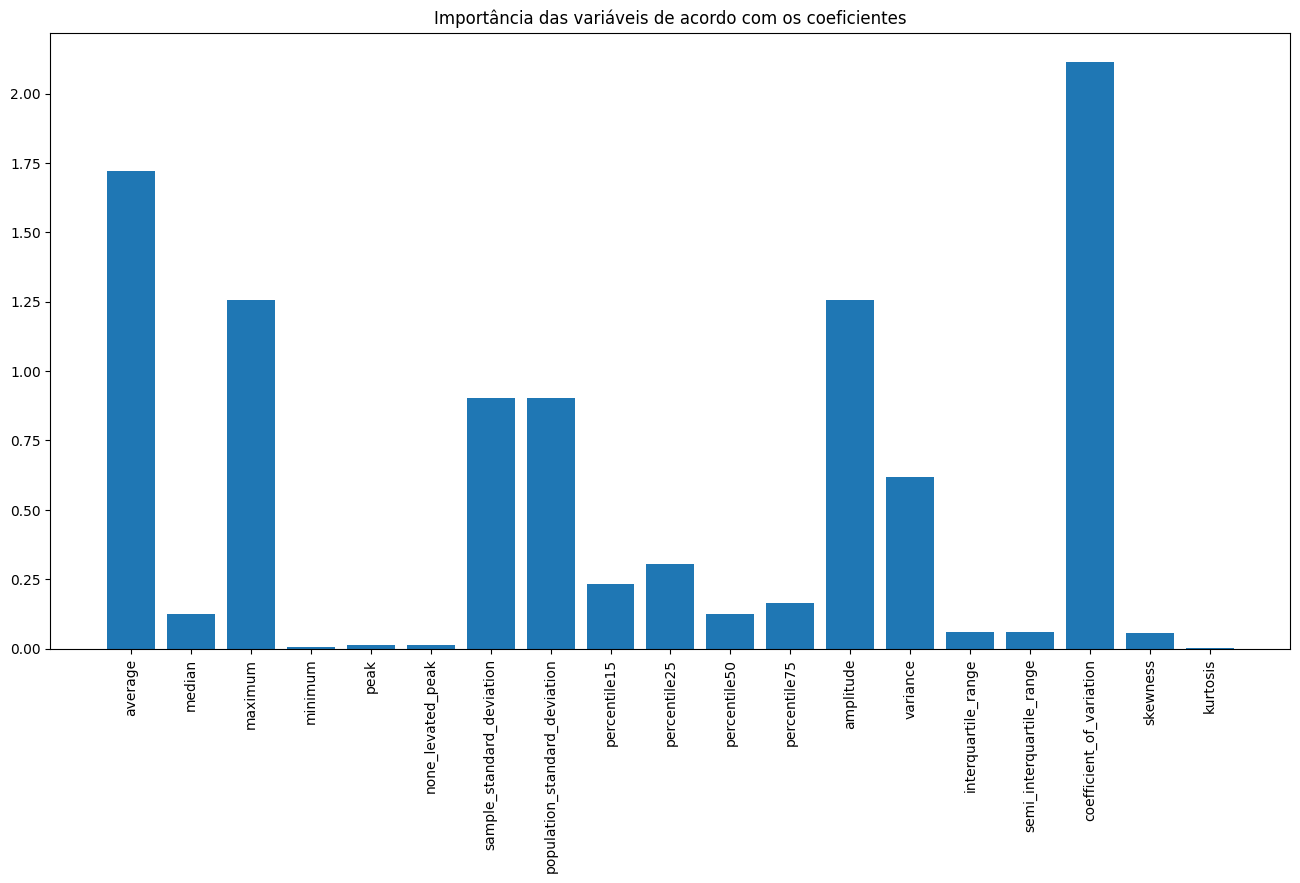

In [23]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train_normalized, y_train)
importance = np.abs(ridge.coef_)
feature_names = np.array(X_train_normalized.columns)

plt.figure(figsize=(16, 8))
plt.bar(height=importance, x=feature_names)
plt.title("Importância das variáveis de acordo com os coeficientes")
plt.xticks(rotation=90)
plt.show()

In [24]:
from sklearn.feature_selection import SelectFromModel

# Selecionando as 6 variáveis com os maiores coeficientes
threshold = np.sort(importance)[-7] + 0.01

sfm = SelectFromModel(ridge, threshold=threshold).fit(X_train_normalized, y_train)

print(f"Variáveis selecionadas pelo SelectFromModel: {feature_names[sfm.get_support()]}")

Variáveis selecionadas pelo SelectFromModel: ['average' 'maximum' 'sample_standard_deviation'
 'population_standard_deviation' 'amplitude' 'coefficient_of_variation']


In [25]:
# Dataset final
X_train_normalized = X_train_normalized[['average', 'maximum', 'sample_standard_deviation',
 'population_standard_deviation', 'amplitude', 'coefficient_of_variation']]

X_test_normalized = X_test_normalized[['average', 'maximum', 'sample_standard_deviation',
 'population_standard_deviation', 'amplitude', 'coefficient_of_variation']]
X_train_normalized

average   maximum  sample_standard_deviation  \
68719  -0.546784 -0.283861                  -0.392361   
1318   -0.548268 -0.283872                  -0.392516   
138115 -0.543371 -0.283836                  -0.392051   
81106  -0.488166 -0.282671                  -0.383025   
140371 -0.461157 -0.281698                  -0.377554   
...          ...       ...                        ...   
119879 -0.432070 -0.280224                  -0.370126   
103694 -0.517549 -0.283471                  -0.388624   
131932 -0.529422 -0.283668                  -0.390286   
146867 -0.394525 -0.277814                  -0.359518   
121958 -0.415746 -0.279170                  -0.365195   

        population_standard_deviation  amplitude  coefficient_of_variation  
68719                       -0.392370  -0.283860                 -0.801487  
1318                        -0.392525  -0.283871                 -0.816811  
138115                      -0.392060  -0.283836                 -0.784521  
81106                       -0.383028  -0.282671                 -0.514499  
140371                      -0.377556  -0.281697                 -0.448404  
...                               ...        ...                       ...  
119879                      -0.370127  -0.280223                 -0.361665  
103694                      -0.388630  -0.283470                 -0.645180  
131932                      -0.390293  -0.283667                 -0.692682  
146867                      -0.359517  -0.277813                 -0.270239  
121958                      -0.365195  -0.279169                 -0.307684  

[118373 rows x 6 columns]

# Modelagem

Visualização dos dados para escolha do modelo


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_plot = pca.fit_transform(X_train_normalized)

In [27]:
df_plot = pd.DataFrame(X_plot)

df_plot['target'] = y_train

In [28]:
import plotly.express as px
fig = px.scatter(df_plot, x=0, y=1,color = 'target')
fig.show()

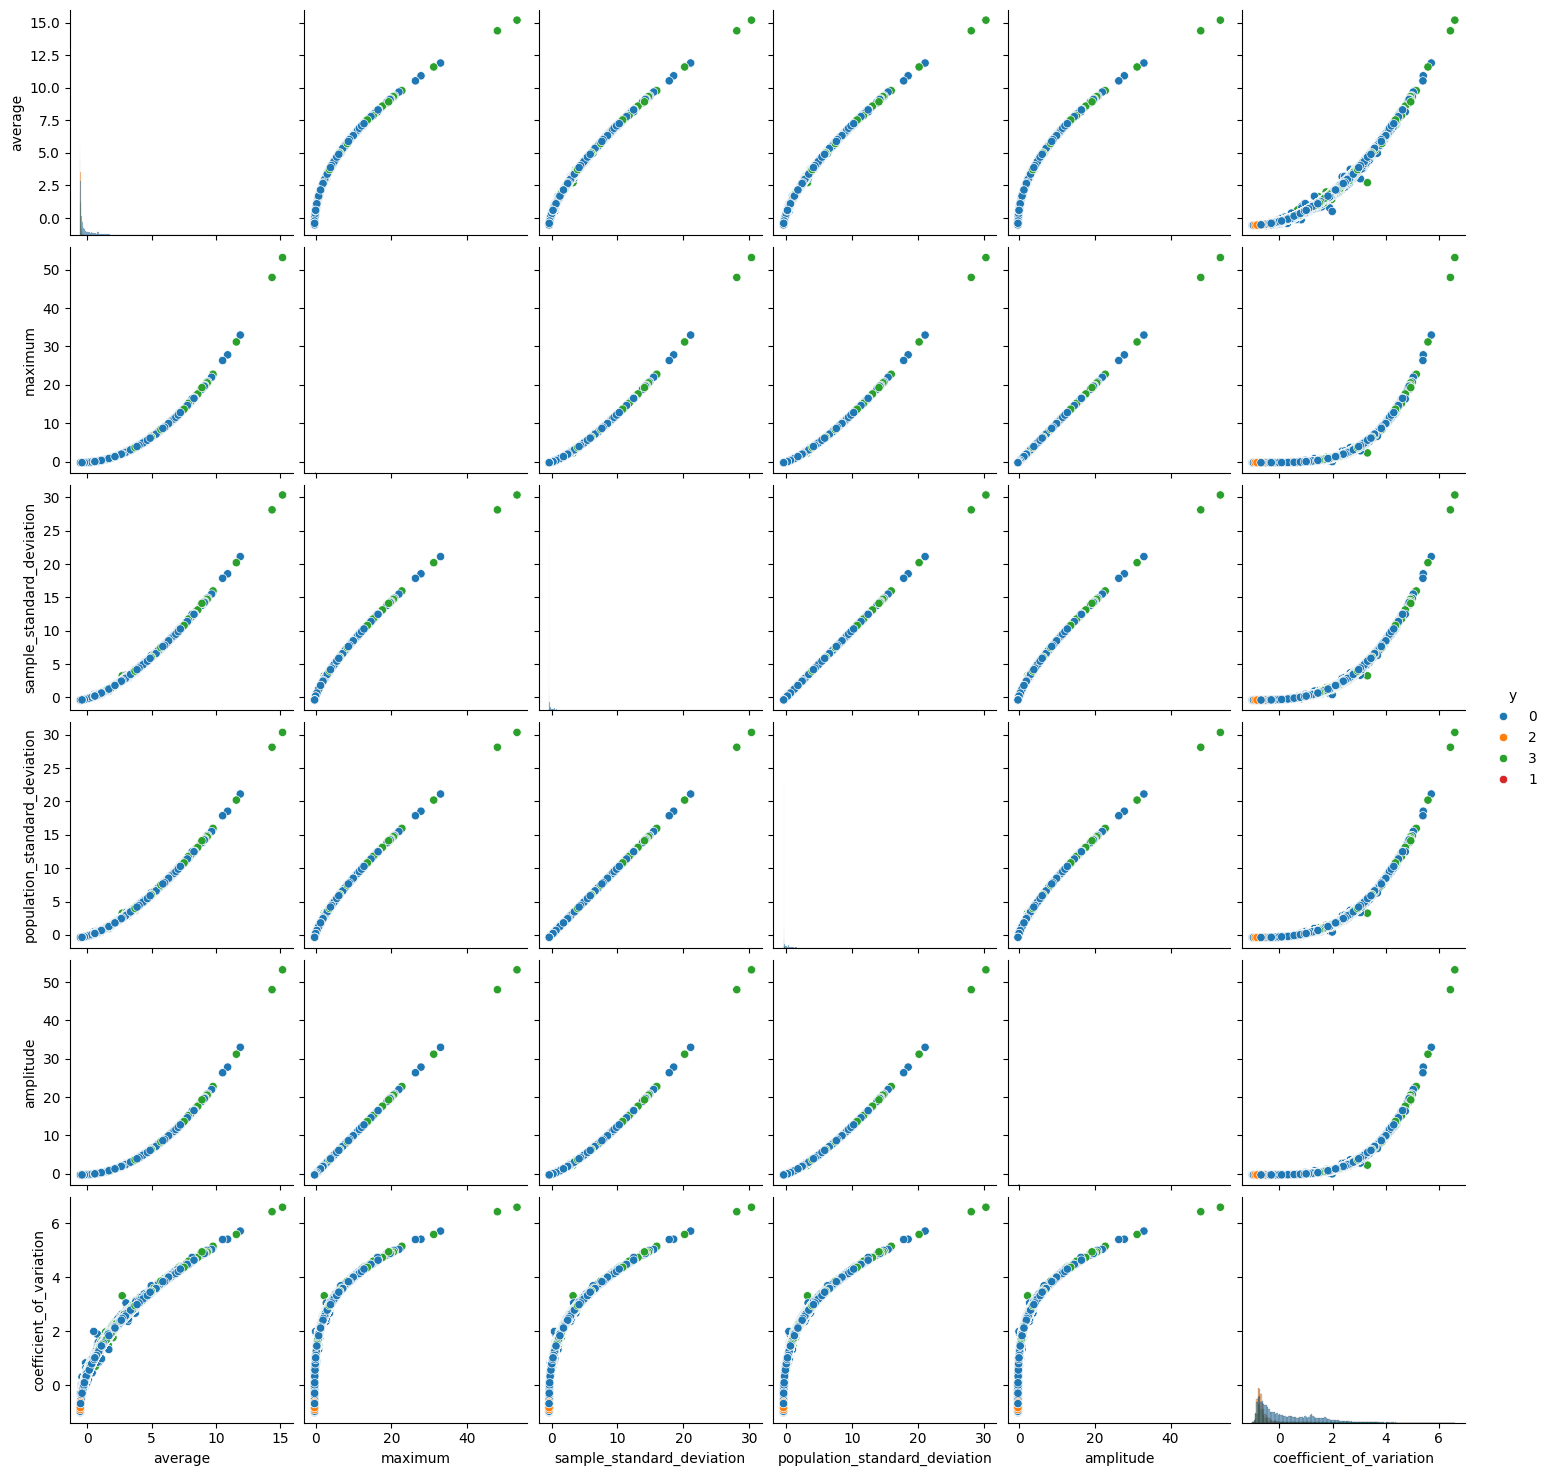

In [47]:
from seaborn import pairplot

df_pairplot = X_train_normalized.copy()
df_pairplot['y'] = y_train

pairplot(df_pairplot, hue='y', diag_kind="hist")

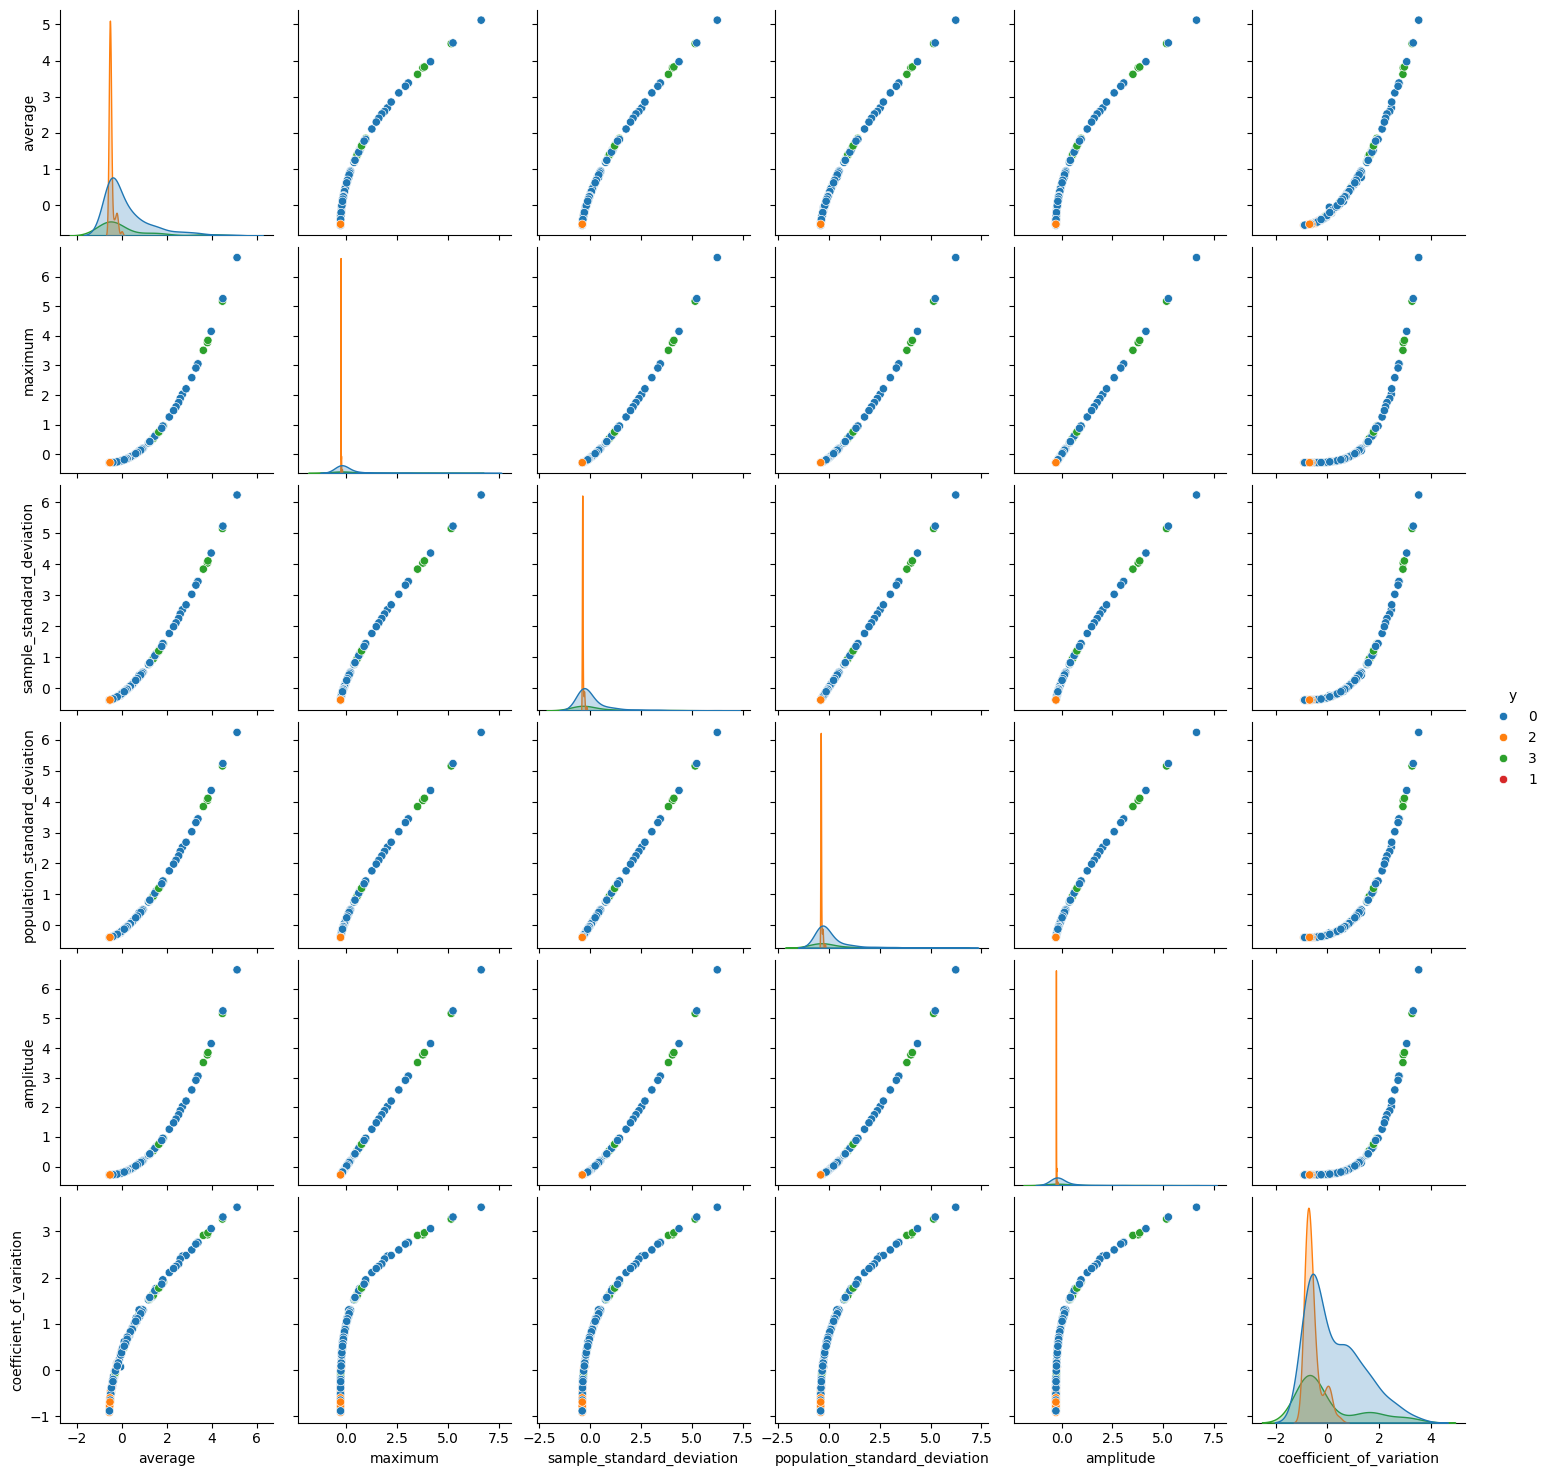

In [48]:
df_pairplot_sample = df_pairplot.sample(300)

pairplot(df_pairplot_sample, hue='y')

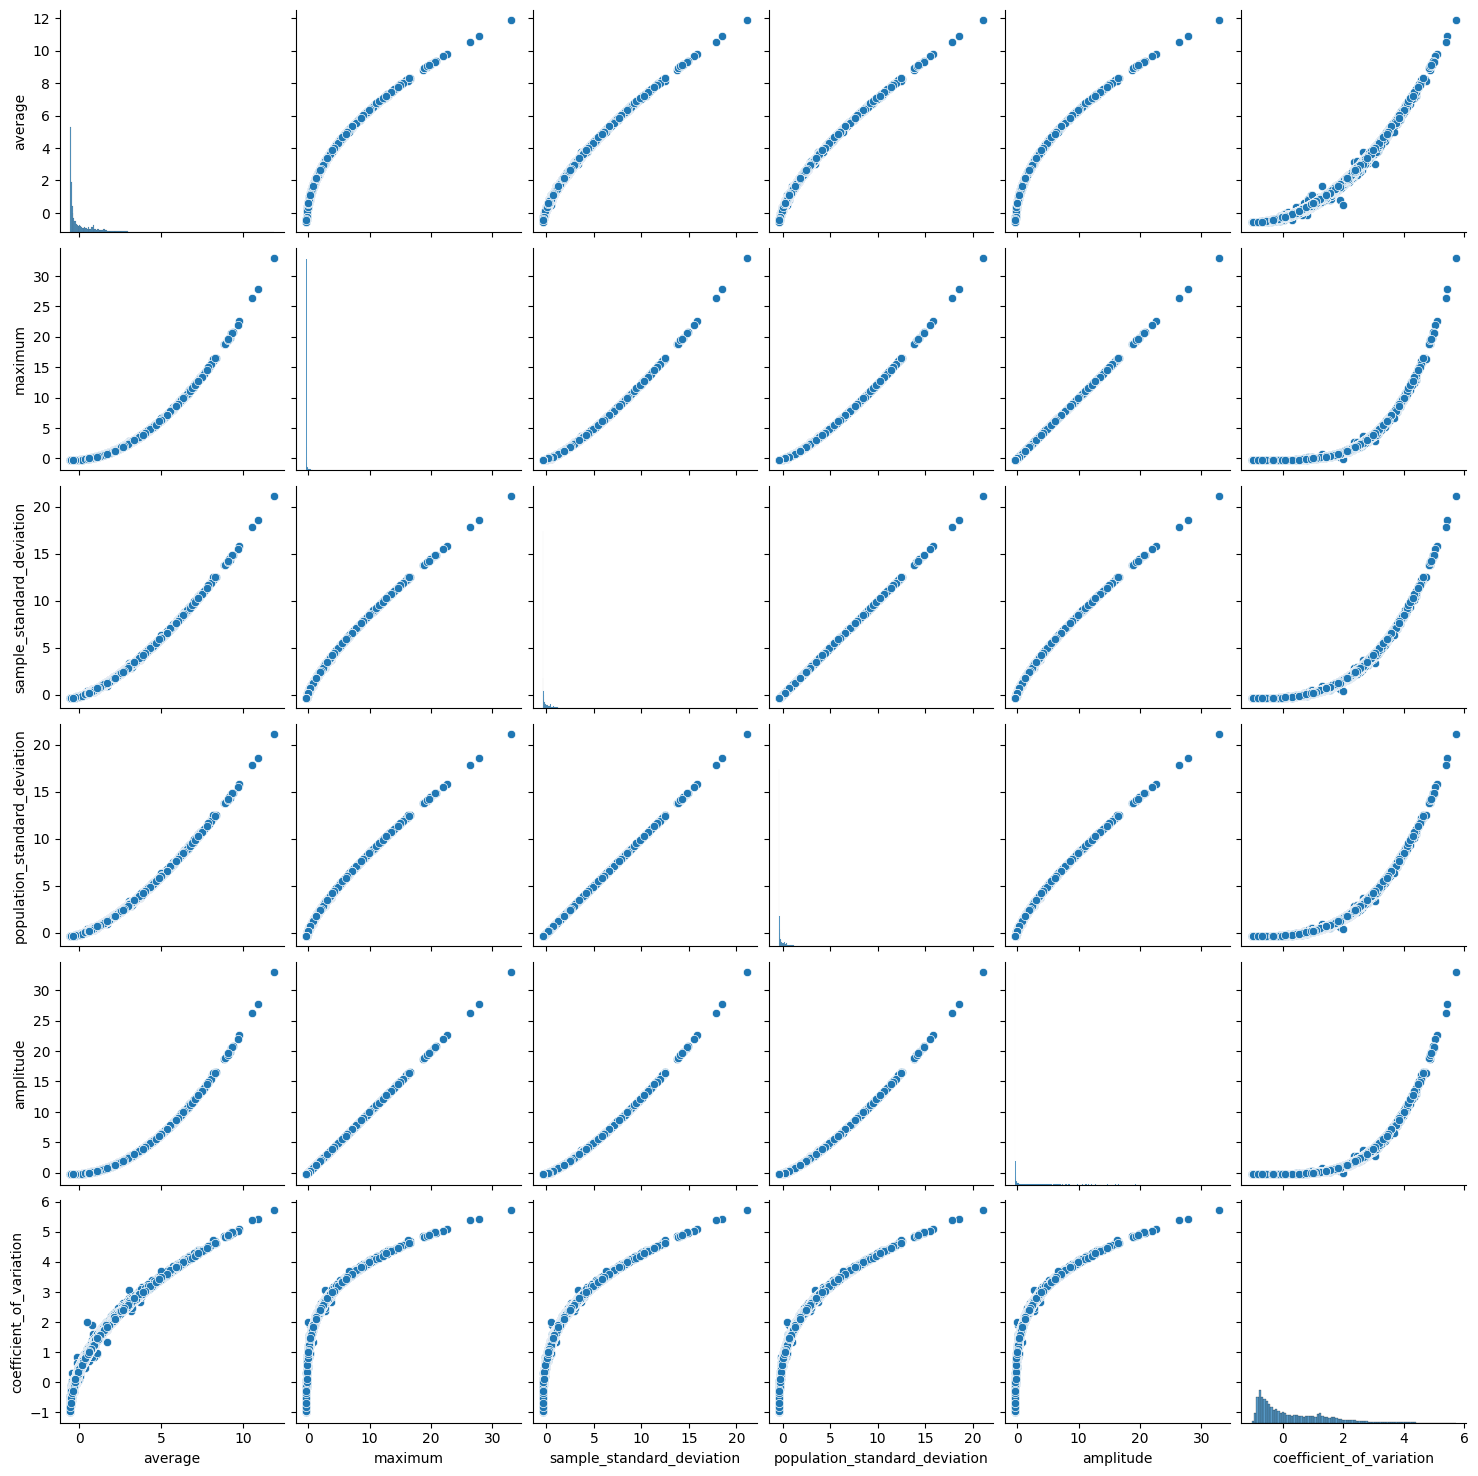

In [54]:
df_pairplot_0 = df_pairplot[df_pairplot['y'] == '0']

sns.pairplot(df_pairplot_0)

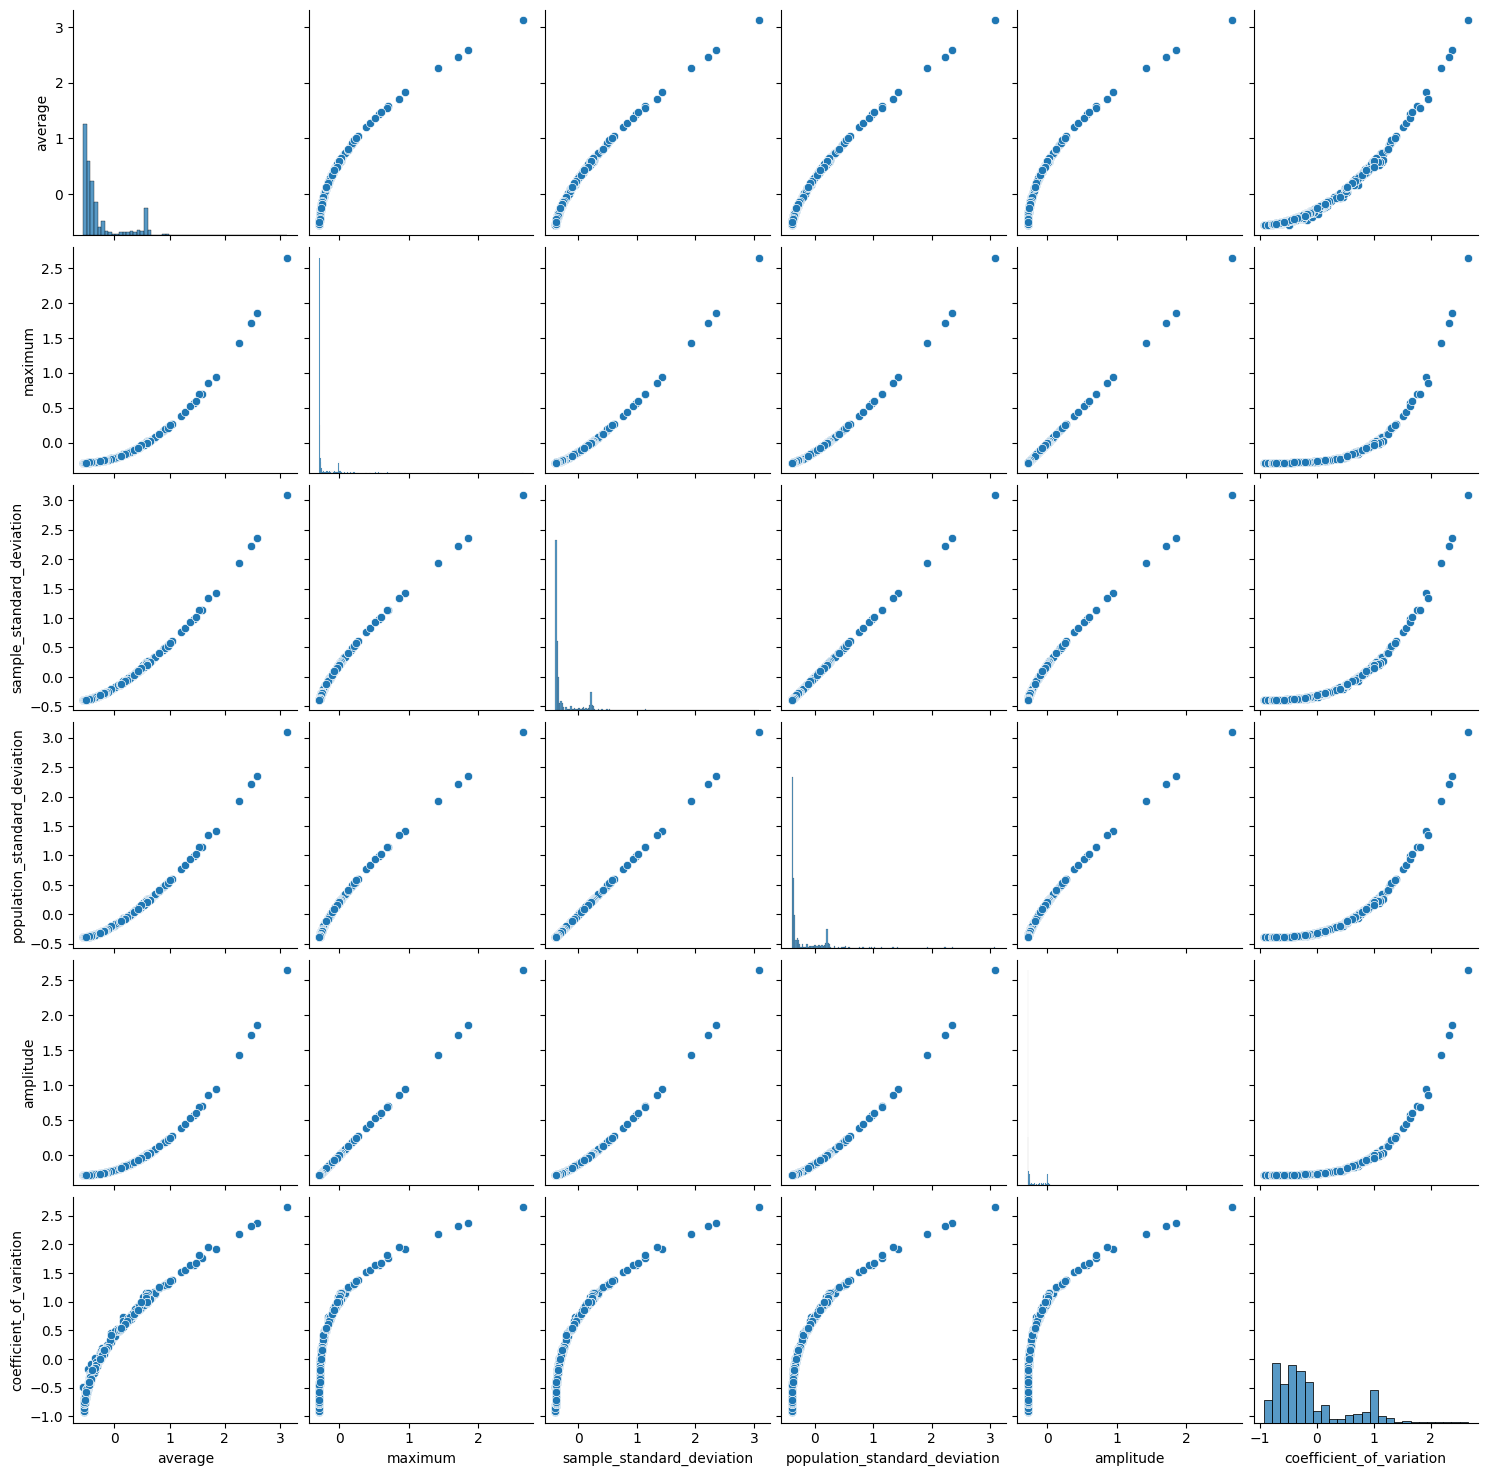

In [55]:
df_pairplot_1 = df_pairplot[df_pairplot['y'] == '1']

sns.pairplot(df_pairplot_1)

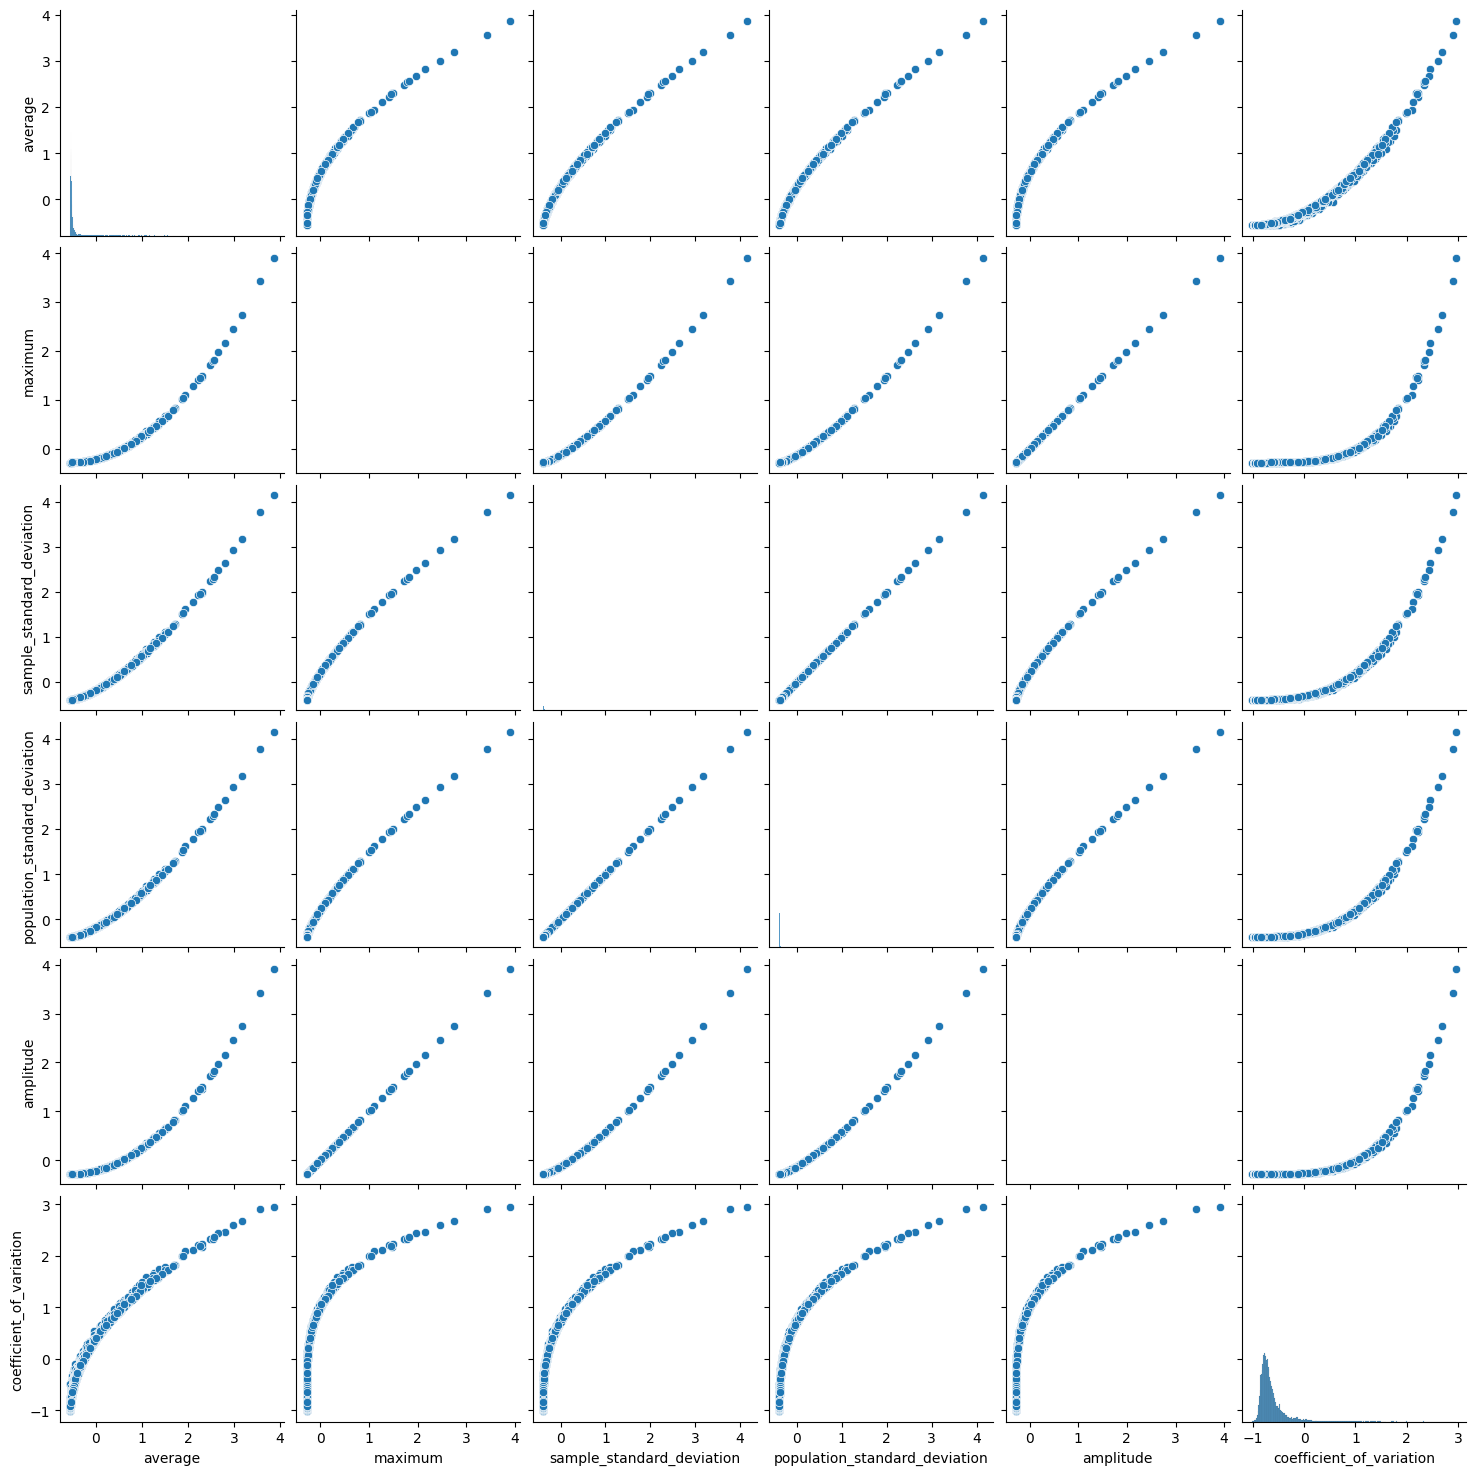

In [56]:
df_pairplot_2 = df_pairplot[df_pairplot['y'] == '2']

sns.pairplot(df_pairplot_2)

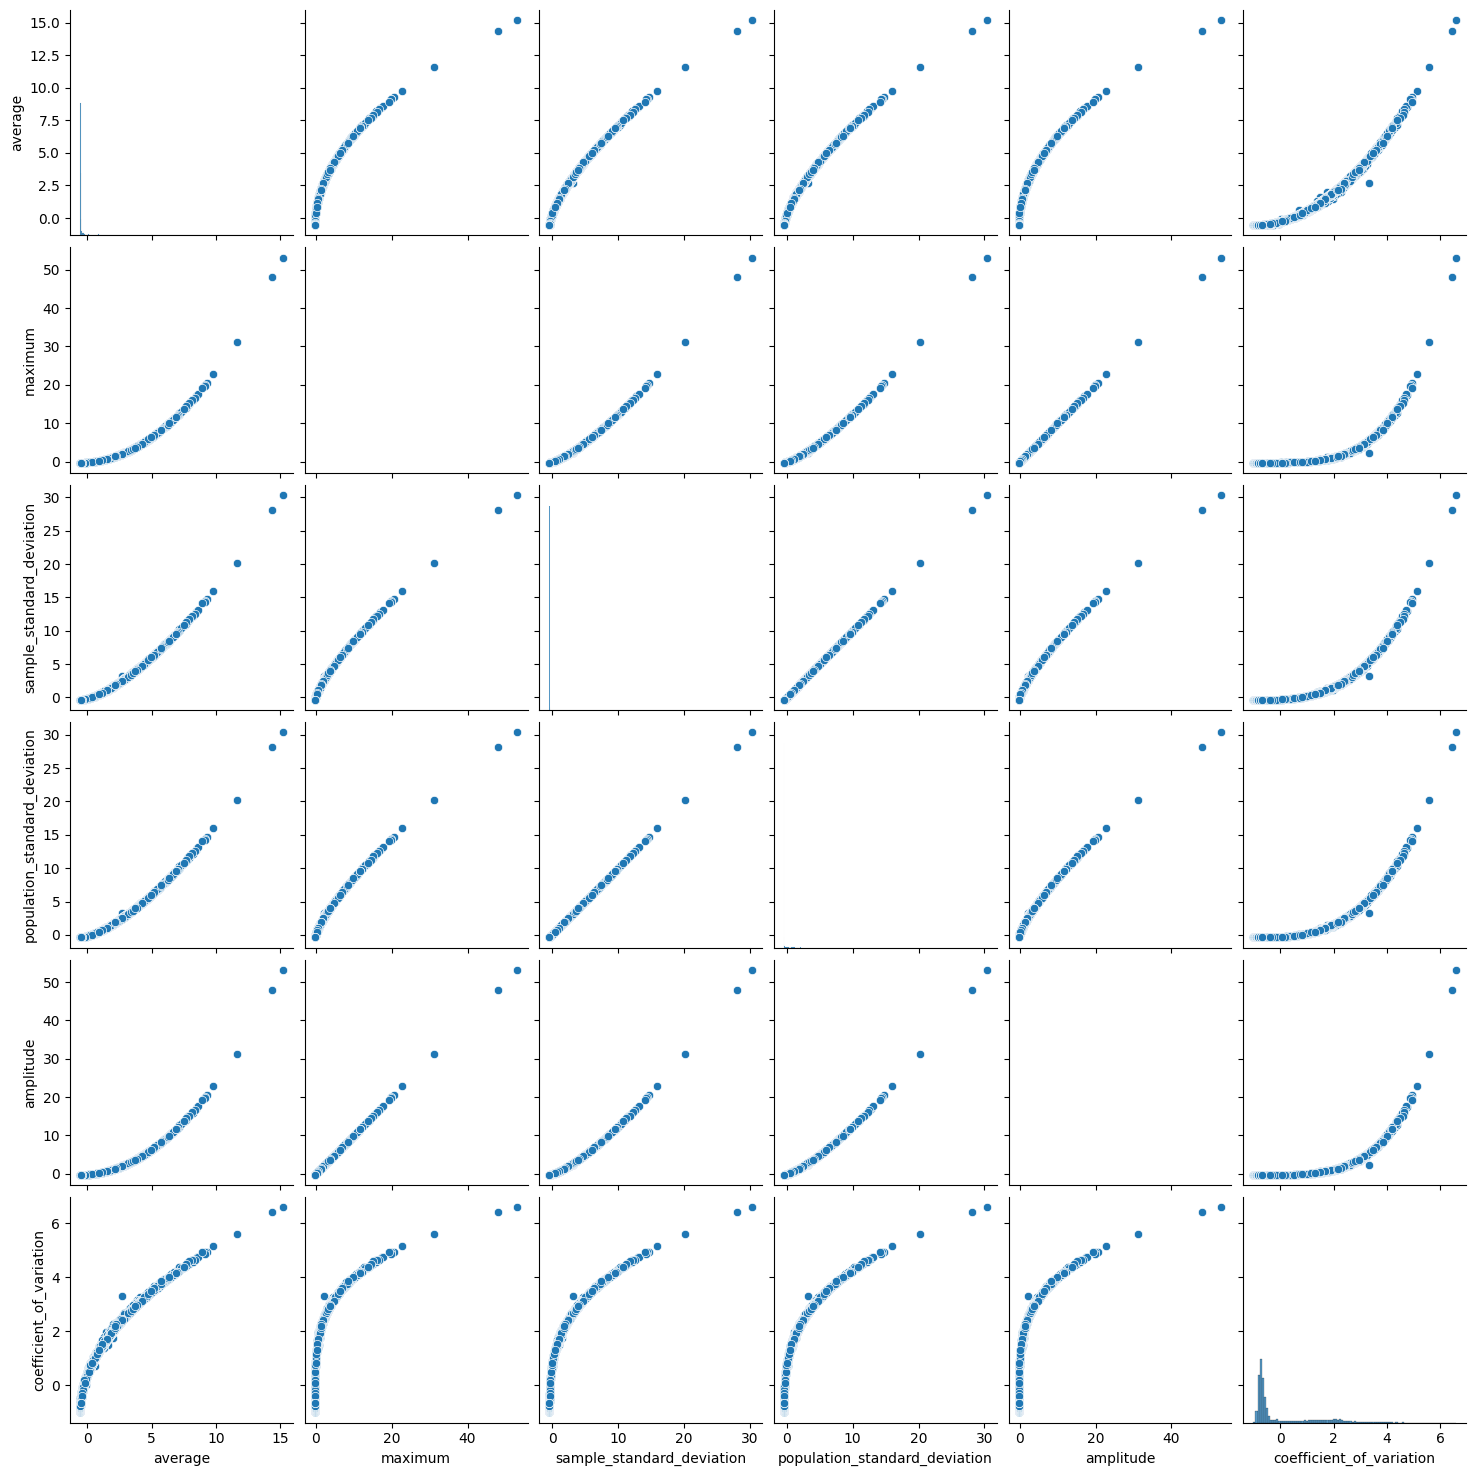

In [57]:
df_pairplot_3 = df_pairplot[df_pairplot['y'] == '3']

sns.pairplot(df_pairplot_3)

Visto que não conseguimos observar separação aparente entre os dados de diferentes classes, acreditamos que o resultado final não será um modelo com grande performance, dado que não há características nos dados diferindo as diferentes classes. Por exemplo, a classe 0 é a mais representada e aparece em todo o conjunto de dados, portanto é difícil encontrar um modelo capaz de diferenciar essa classe das demais.

In [29]:
# Parametros para testar no modelo utilizado
parameters = {
        'n_estimators':list(range(120,151)),
        'learning_rate':[0.3, 0.5, 0.7, 1],
        'max_depth': [1, 2]
    }

Abaixo utilizamos o GridSearchCV, que testa permutações de parâmetros em um modelo até encontrar o melhor, considerando o algoritmo de validação cruzada K-Fold, para o trabalho, escolhemos utilizar o 3-Fold, para economizar tempo em comparação com o 5-Fold.  
  
O código está comentado pois não recomendamos executá-lo, já foi executado e o melhor modelo encontrado é o utilizado posteriormente.

In [30]:
# from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# gb = GradientBoostingClassifier()
# clf = GridSearchCV(gb, parameters, cv=3)

# clf.fit(X_train_normalized, y_train)

In [31]:
# clf.best_estimator_

Treinando o melhor modelo encontrado pelo GridSearchCV

In [32]:
# Treinando o melhor modelo encontrado pelo GridSearchCV
clf = GradientBoostingClassifier(learning_rate=1, max_depth=1, n_estimators=145)
clf.fit(X_train_normalized, y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=1, n_estimators=145)

In [33]:
# Avaliando a acurácia do modelo
clf.score(X_test_normalized, y_test)

0.6321651028936371

In [34]:
# Encontrando a PR_AUC média, dado que a tarefa de classificação não é binária
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Performance para cada classe
precision = dict()
recall = dict()
average_auc = dict()

# Transformações para computar os valores de performance
y_test_onehot = pd.get_dummies(y_test).values
y_prob = clf.predict_proba(X_test_normalized)

# Computa os valores de performance para cada classe
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test_onehot[:, i],
                                                        y_prob[:, i])
    average_auc[i] = auc(recall[i], precision[i])


# Média do valor de PR_AUC para todas as classes
mean_pr_auc = np.mean(list(average_auc.values()))

print(f'O valor de PR_AUC médio para as classes foi de {round(mean_pr_auc,2)}')

O valor de PR_AUC médio para as classes foi de 0.36


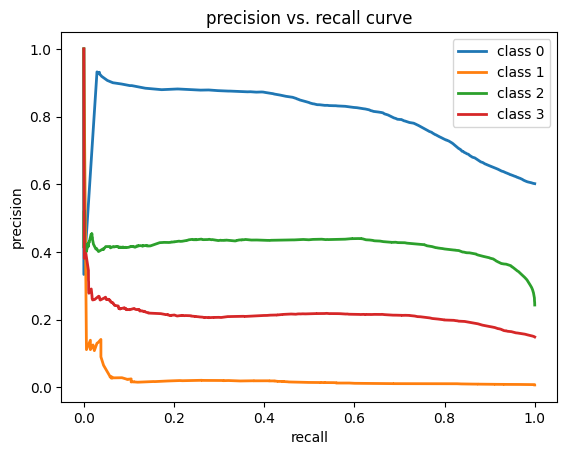

In [35]:
# Analisando o resultado

# Plota a curva PR para cada classe
for i in range(4):
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()